In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap

import networkx as nx

from minimal.imaging import blit_rooms
from minimal.layout import LayoutGraph, NodeType
from minimal.gen import generate_plan, PlanMasks
from minimal import sample_graphs
from minimal.correction import RoomAreas

%matplotlib inline

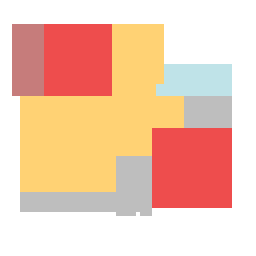

<PlanMasks 137104787303680>

In [4]:
pm = PlanMasks.create_from_state(torch.load("data/plan_masks_01.pth"))
pm

In [49]:
%%time

min_area_units = 10
rooms = []
masks = []
for i, node in enumerate(pm.graph.nodes):
    if not NodeType.is_room(node):
        continue

    room = RoomAreas(node, pm.masks[i])
    room.threshold_rectangles(min_area_units)
    room.discard_small_components()
    masks.append(room.to_mask())
    rooms.append(room)

CPU times: user 1.55 s, sys: 0 ns, total: 1.55 s
Wall time: 1.54 s


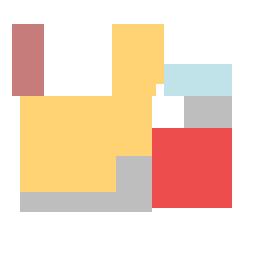

In [50]:
blit_rooms(rooms)

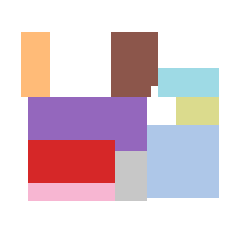

In [51]:
room_index_mask = sum(room.to_mask() * (i + 1) for i, room in enumerate(rooms))
room_index_mask.shape

plt.figure(figsize=(3,3))
cmap = ListedColormap(['white', *plt.get_cmap('tab20').colors])
plt.axis("off")
plt.imshow(room_index_mask, cmap=cmap)

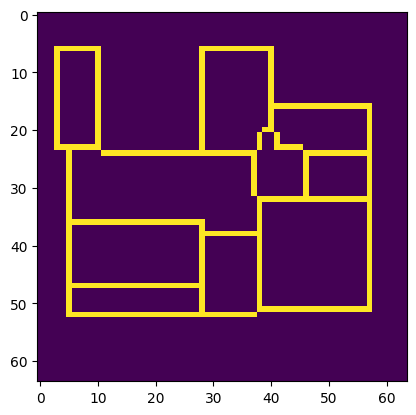

In [82]:
# plt.figure(figsize=(3,3))
plt.imshow(all_walls)

In [81]:
inner_mask = torch.zeros_like(masks[0])
inner_walls = torch.zeros_like(masks[0])

for i in range(len(masks)):
    inner_mask += masks[i]
    for j in range(i + 1, len(masks)):
        inner_walls += walls_between(masks[i], masks[j])

inner_mask.clamp_(0, 1)
inner_walls.clamp_(0, 1)

outer_mask = (1 - inner_mask).byte()

# TODO:
outer_walls = walls_between(inner_mask, outer_mask)

all_walls = (inner_walls + outer_walls).clamp_(0, 1)

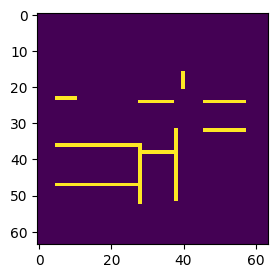

In [47]:
def walls_between(room, check_room):
    e_top = down((up(room) + check_room == 2).byte())
    e_bottom = up((down(room) + check_room == 2).byte())

    e_left = right((left(room) + check_room == 2).byte())
    e_right = left((right(room) + check_room == 2).byte())

    return (e_top + e_right + e_left + e_bottom).clamp_(0, 1)


In [33]:
def up(m):
    """Shifts a 2D mask `m` up"""
    top, rest = m[:1, :], m[1:, :]
    return torch.cat([rest, top], dim=0)

def down(m):
    """Shifts a 2D mask `m` down"""
    rest, bottom = m[:-1, :], m[-1:, :]
    return torch.cat([bottom, rest], dim=0)

def left(m):
    """Shifts a 2D mask `m` left"""
    first, rest = m[:, :1], m[:, 1:]
    return torch.cat([rest, first], dim=1)

def right(m):
    """Shifts a 2D mask `m` down"""
    rest, last = m[:, :-1], m[:, -1:]
    return torch.cat([last, rest], dim=1)